# Etape1:Extraction des images

# Input:Une base de données de vidéos




In [1]:
from PIL import Image
from os import listdir
from os.path import isfile, join
import cv2
import os
from pathlib import Path
from os.path import basename
def getFrame(sec):
    dir=listdir('/content/data')
    for i in range(len(dir)):

      dd=os.path.join('/content/data', dir[i])
      vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
      hasFrames,image = vidcap.read()
    
      if hasFrames:

         cv2.imwrite(str(x)+'/'+label+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

mypath = "/content/drive/My Drive/face_dataset/video_input"

videosFiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) and (f.endswith(("mp4")) or f.endswith(("vip"))) ]

count=1
for vid in videosFiles:
    y=list()
    label,extent=os.path.splitext(vid)
    y.append(label)
    vidcap = cv2.VideoCapture(join(mypath,vid)) 
    try:

      if not os.path.exists('data'+'/'+label): 

		       os.makedirs('data'+'/'+label) 

    except OSError: 
         
	    print ('Error: Creating directory of data')
    dd=os.path.join('/content/data',label)
    x=Path(dd)

    sec = 0
    frameRate = 0.5 #//it will capture image in each 2 second
    success = getFrame(sec)
    while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec)
print('Done!!') 

Done!!


# Détection

In [2]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 43kB/s 


In [0]:
import numpy as np # linear algebra
import pandas as pd 
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from os import listdir
from os.path import isfile, join
import os
from PIL import ImageEnhance
from PIL import  ImageFilter

def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # processing
    # convert to RGB, if needed
    image = image.convert('RGB')
   
    # convert to array
    pixels = np.asarray(image)
    #pixels=cv2.filter2D(pixels, -1, np.array([[1 for i in range(3)] for j in range(3)], dtype = np.float) / 9)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array
    

# Split data

In [4]:
pip install split-folders

In [5]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('/content/data', output="output1", seed=1337, ratio=(.8, .1, .1)) # default values



Copying files: 80 files [00:00, 2159.84 files/s]


# Téléchargement de données

In [58]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/output1/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/output1/test/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('videos-faces-dataset.npz', trainX, trainy, testX, testy)

loaded 16 sample for class: Locas
loaded 16 sample for class: yousra
loaded 16 sample for class: jenniffer
loaded 16 sample for class: alix
(64, 160, 160, 3) (64,)
loaded 2 sample for class: Locas
loaded 2 sample for class: yousra
loaded 2 sample for class: jenniffer
loaded 2 sample for class: alix
(8, 160, 160, 3) (8,)


In [59]:
data = np.load('videos-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (64, 160, 160, 3) (64,) (8, 160, 160, 3) (8,)


# Téléchargement de FaceNet

In [15]:
facenet_model = load_model('/content/drive/My Drive/facenet1/facenet_keras.h5')
print('Loaded Model')

Loaded Model


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Extraire les features

In [60]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('videos-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(64, 128)
(8, 128)


# Classification des features

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=64, test=8
Accuracy: train=100.000, test=100.000


# Identification

Predicted: 
['Locas' 'alix' 'jenniffer' 'yousra'] 
[ 4.62119131  3.0035802   4.52749299 87.84773551]
Expected: yousra


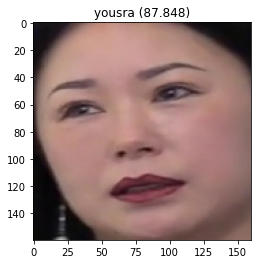

In [62]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()